# PA1: K-Nearest Neighbors [160 marks]

<center>
    <img src="https://machinelearningmastery.com/wp-content/uploads/2019/10/Develop-k-Nearest-Neighbors-in-Python-From-Scratch.png">
</center>

### Introduction

In this assignment, you will be creating your second Machine Learning model from scratch: K-Nearest Neighbors.

This algorithm is one of the simpler ones you will come across, but the ideas can be applied to large-scale sophisticated systems: Semantic Search and Recommendation Systems for starters.

For this assignment, you will be creating your own KNN-classifier from scratch using `numpy`. You can then use this to classify images of *handwritten digits* from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This is the "Hello World" of Machine Learning.

We will also be introduce a new type of nearest neighbor classifier later on.

After this notebook you should be able to:

- Utilize `numpy` to implement a simple KNN classifier from scratch

- Understand how to setup a good Cross Validation strategy

- Be able to setup simple classification tasks

### Instructions

- Follow along with the notebook, filling out the necessary code where instructed.
- <span style="color: red;">Read the Submission Instructions and Plagiarism Policy in the attached PDF.</span>

- <span style="color: red;">Make sure to run all cells for credit.</span>

- <span style="color: red;">Do not remove any pre-written code.</span> Your assignment will be graded based off your output.

- <span style="color: red;">You must attempt all parts.</span> Do not assume that because something is for 0 marks, you can leave it - it will definitely be used in later parts.

- <span style="color: red;">Do not use unauthorized libraries.</span> You are not allowed to use `sklearn` in Part 1 & 3. Failure to follow these instructions will result in a serious penalty.


## Part 1: KNNs from Scratch [100 marks]

Again, you are <span style="color: red;">not allowed</span> to use scikit-learn or any other machine learning toolkit for this part. You have to implement your own k-NN classifier from scratch.

### Importing Libraries
All of the necessary libraries for this part have been imported for you below. You may not use any other library apart from standard Python librares.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import PIL
!pip install idx2numpy
import idx2numpy

### Task 1: Extracting the dataset [12 marks]
The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels, yielding a total of 784 pixels per picture.

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This value ranges from 0-255

The dataset can be downloaded from [here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) and is also available to in your assignment directory. The four relevant files in the folder are:
- train-images-idx3-ubyte: training set images
- train-labels-idx1-ubyte: training set labels
- t10k-images-idx3-ubyte: test set images
- t10k-labels-idx1-ubyte: test set labels

The dataset has been split with 60,000 images in the train set, and the remaning 10,000 images in the test set.

Your very first task is to to convert this dataset into a pandas dataframe.

Hint: *use the idx2numpy package to convert the dataset to a multidimensional numpy array. The documentation can be visited [here](https://pypi.org/project/idx2numpy/). The resulting array then has to be flattened.*

In [2]:
train_images_path = '/train-images.idx3-ubyte'
train_labels_path = '/train-labels.idx1-ubyte'
test_images_path = '/t10k-images.idx3-ubyte'
test_labels_path = '/t10k-labels.idx1-ubyte'

train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [3]:
train_images_flattened = train_images.reshape(train_images.shape[0], -1)
df_train = pd.DataFrame(train_images_flattened)
df_train['label'] = train_labels

test_images_flattened = test_images.reshape(test_images.shape[0], -1)
df_test = pd.DataFrame(test_images_flattened)
df_test['label'] = test_labels

QUESTION: What does each row of the dataset represents? [2 marks]

ANSWER: Each row contains the pixel data of a picture, which act as the features, and the label of the picture. So each row represents the data for a picture.

### Task 2: Visualizing and preprocessing the dataset [12 marks]

Now that we have a dataset to work with, we need to preprocess it further, before we pass it through our classifier. In this step, we will be seperating out the labels from the inputs, and attempt to standardize or normalize our dataset.

Note that the standardization of a variable $x$ refers to:
$$
x' = \frac{x - μ}{σ}
$$

where $μ$ is the mean of the variable and $σ$ is the standard deviation.

On the other hand, variable normalization usually involves scaling the data to a specific range.

You can read more about this [here](https://www.simplilearn.com/normalization-vs-standardization-article).

After you've loaded and split the dataset, let's display some images. You can reshape these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.

In [4]:
train_x = train_images.reshape(train_images.shape[0], -1)
train_y = train_labels
test_x = test_images.reshape(test_images.shape[0], -1)
test_y = test_labels

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(60000, 784)
(60000,)
(10000, 784)
(10000,)


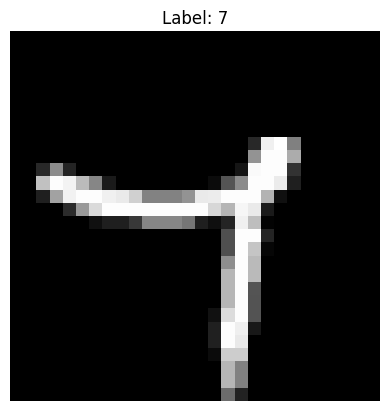

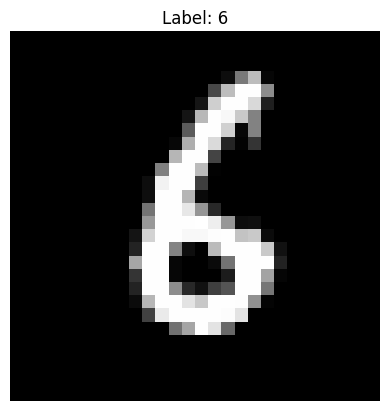

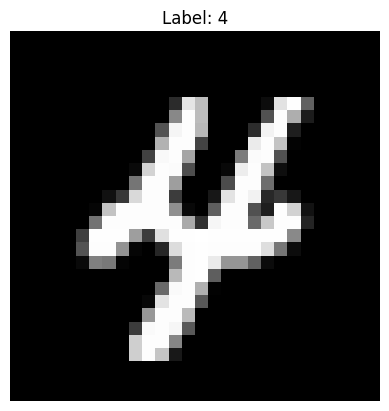

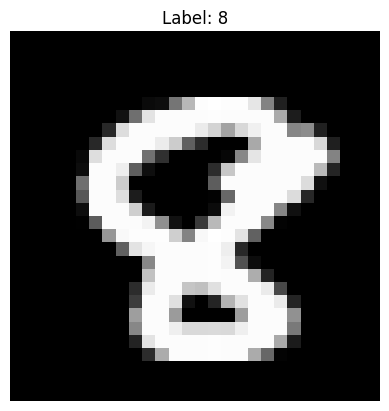

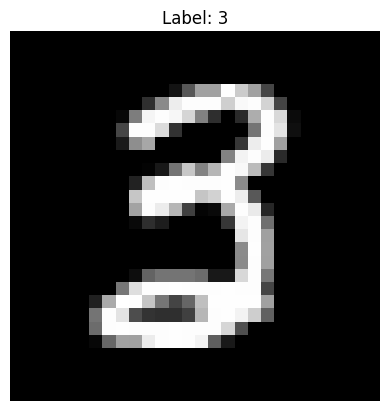

In [5]:
def display_image(features, label):
    image = features.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

random_indices = np.random.choice(train_x.shape[0], 5, replace=False)
for index in random_indices:
    display_image(train_x[index], train_y[index])


In [6]:
def normalize(data):
  return data / 255.0

train_x_normalized = normalize(train_x)
test_x_normalized = normalize(test_x)

QUESTION: With the variable standardization formula shown above in the description, is this technique feasible in this dataset? Explain in detail. [2 marks]

ANSWER:  Standardization is not feasible for the MNIST dataset as it is not necessary or the best option for pixel intensity values that are already on a consistent scale. For MNIST, normalization is preferred over standardization, as it preserves the nature of the pixel values and simplifies training, especially for models like neural networks and KNN. Standardization could introduce unnecessary complexity without substantial benefits for this dataset.

### Task 3: Implementing k-NN Classifier [20 marks]

Now you can create your own k-NN classifier. You can use the following steps as a guide:

1. For a test data point, find its distance from all training instances.

2. Sort the calculated distances in ascending order based on distance values.

3. Choose k training samples with minimum distances from the test data point.

4. Return the *most frequent* class of these samples.

For values of `k` where a tie occurs, you need to break the tie by backing off to the `k-1` value. In case there is still a tie, you will continue decreasing `k` until there is a clear winner.

#### Important
**Note:** Your function should work with *Euclidean* distance as well as *Manhattan* distance. Pass the distance metric as a parameter in the k-NN classifier function. Your function should also let one specify the value of `k`.

**Note:** Your approach should be vectorized. Failure to implement a vectorization-based method to calculate distances will result in significant loss of marks. You can read up vectorization [here](https://towardsdatascience.com/vectorization-implementation-in-machine-learning-ca652920c55d)

#### Distance functions

Implement separate functions for the Euclidean and Manhattan distances. Formulas for both are given below.

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$


---

Complete the following method functions:
- `euclidean_distance`
- `manhattan_distance`
- `fit`
- `get_neighbors`
- `predict`


In [7]:
class KNN:
    def __init__(self, k):
        self.k = k
        self.train_x = None
        self.train_y = None

    def euclidean_distance(self, x1, x2):
       return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

    def manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2), axis=1)

    def fit(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y

    def get_neighbors(self, new_point, distancefunc):
        distances = distancefunc(new_point, self.train_x)
        indices = np.argsort(distances)[:self.k]
        neighbors_labels = self.train_y[indices]

        return neighbors_labels

    def predict(self, test_x, distancefunc):
        predictions = []
        for new_point in test_x:
            neighbors = self.get_neighbors(new_point, distancefunc)
            unique, counts = np.unique(neighbors, return_counts=True)
            most_common = unique[np.argmax(counts)]
            predictions.append(most_common)

        return np.array(predictions)


### Task 4: Evaluation [24 marks]

Now that you've created a model and "trained" it, you can move on to the Evaluation phase.

- We will be implementing an `evaluate` function that computes the Confusion Matrix, Accuracy, and Macro-Average F1 score of your classifier. You can use multiple helper functions to calculate the individual metrics.

- The function should take as input the predicted labels and the true labels. This will be built in steps: its easier to create a Confusion Matrix, then calculate things like the Precision, Recall and F1 from it.

- We will also implement a function that displays our confusion matrix as a heatmap annotated with the data values.
- The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.
- You can have a look at some examples of heatmaps [here](https://seaborn.pydata.org/generated/seaborn.heatmap.html). (You don't have to use the seaborn libray, but it has some pretty colour palettes to choose from.)

We recommend that you do not use hard coding in this function.



---

Complete the following functions:

- `accuracy`
- `make_confusion_matrix`
- `make_heat_map`
- `precision`
- `recall`
- `f1_score`
- `macro_average_f1`
- `evaluate`





In [8]:
def accuracy(predicted_labels, true_labels):
    return np.sum(predicted_labels == true_labels) / len(true_labels)

def make_confusion_matrix(predicted_labels, true_labels):
    unique_labels = np.unique(true_labels)
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)
    for i, true_label in enumerate(unique_labels):
        for j, pred_label in enumerate(unique_labels):
            confusion_matrix[i, j] = np.sum((true_labels == true_label) & (predicted_labels == pred_label))

    return confusion_matrix

def make_heat_map(confusion_matrix, title):
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, square=True)
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(ticks=np.arange(len(np.unique(train_y))) + 0.5, labels=np.unique(train_y), rotation=45)
    plt.yticks(ticks=np.arange(len(np.unique(train_y))) + 0.5, labels=np.unique(train_y), rotation=0)
    plt.tight_layout()
    plt.show()

    return heatmap

def precision(confusion_matrix, class_label):
    true_positives = confusion_matrix[class_label, class_label]
    false_positives = np.sum(confusion_matrix[:, class_label]) - true_positives
    return true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

def recall(confusion_matrix, class_label):
    true_positives = confusion_matrix[class_label, class_label]
    false_negatives = np.sum(confusion_matrix[class_label, :]) - true_positives
    return true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def macro_average_f1(confusion_matrix):
    f1_scores = []
    for class_label in range(confusion_matrix.shape[0]):
        prec = precision(confusion_matrix, class_label)
        rec = recall(confusion_matrix, class_label)
        f1 = f1_score(prec, rec)
        f1_scores.append(f1)

    return np.mean(f1_scores)

def evaluate(predicted_labels, true_labels):
    conf_matrix = make_confusion_matrix(predicted_labels, true_labels)
    acc = accuracy(predicted_labels, true_labels)
    macro_f1 = macro_average_f1(conf_matrix)
    print(f'Accuracy: {acc:.4f}')
    print(f'Macro-Average F1 Score: {macro_f1:.4f}')
    make_heat_map(conf_matrix, title='Confusion Matrix')

    return acc, macro_f1, conf_matrix

### Task 5: k-fold Cross Validation [20 marks]

<center>
    <img src="https://global.discourse-cdn.com/dlai/original/3X/a/3/a3ed2de61c2b4fa00f1b7e939753e1a7e181afb0.png">
</center>

Now with the basics done, you can move on to the next step: k-fold Cross Validation. This is a more robust way of evaluating your model since it uses all the data for training and testing (effectively giving you `k` chances to verify the generalizability of your model).

Now, implement a function that performs `k`-fold cross-validation on the training data for a specified value of `k`.

In Cross Validation, you divide the dataset into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. You will repeat this process `k` times, each time using a different part for validation. You will then average the results of each fold to get the final result. Take a look at the image above for a better understanding.

The function should return **predictions** for the **entire training data** (size of list/array should be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. Make sure the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to your `evaluate` function together with the actual labels.



---

Complete the following functions:

- `k_fold_split`
- `k_fold_cross_validation`


In [9]:
def k_fold_split(num_folds, cv_no, train_x, train_y):
    fold_size = len(train_x) // num_folds
    start_index = cv_no * fold_size
    end_index = start_index + fold_size if cv_no < num_folds - 1 else len(train_x)
    test_x = train_x[start_index:end_index]
    test_y = train_y[start_index:end_index]
    train_x = np.concatenate([train_x[:start_index], train_x[end_index:]])
    train_y = np.concatenate([train_y[:start_index], train_y[end_index:]])

    return train_x, train_y, test_x, test_y


def k_fold_cross_validation(num_folds, k, train_x, train_y, distanceFunction):
    knn_model = KNN(k)
    num_samples = train_x.shape[0]
    predictions = np.zeros(num_samples)
    fold_size = num_samples // num_folds
    for fold in range(num_folds):
        start = fold * fold_size
        end = start + fold_size if fold != num_folds - 1 else num_samples
        val_x = train_x[start:end]
        val_y = train_y[start:end]
        train_x_fold = np.concatenate((train_x[:start], train_x[end:]), axis=0)
        train_y_fold = np.concatenate((train_y[:start], train_y[end:]), axis=0)
        knn_model.fit(train_x_fold, train_y_fold)
        for i in range(val_x.shape[0]):
            neighbors = knn_model.get_neighbors(val_x[i], distanceFunction)
            predictions[start + i] = statistics.mode(neighbors)

    return predictions

Now run your cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`.

Do this for both the Euclidean distance and the  Manhattan distance for each value of `k`.

Also run your evaluation function for each value of `k` (for both distance metrics) and print out the classification accuracy and F1 score.

**Note: Save your evaluation stats for plotting later**

In [10]:
accuracy_list_euclidean = []
f1_list_euclidean = []
accuracy_list_manhattan = []
f1_list_manhattan = []

data = np.hstack((train_x_normalized, train_y.reshape(-1, 1)))
sampled_data = data[np.random.choice(data.shape[0], 14000, replace=False)]
sampled_train_x = sampled_data[:, :-1]
sampled_train_y = sampled_data[:, -1]

Running KNN with k=1 and distance metric='euclidean'
Accuracy: 0.9507
Macro-Average F1 Score: 0.9499


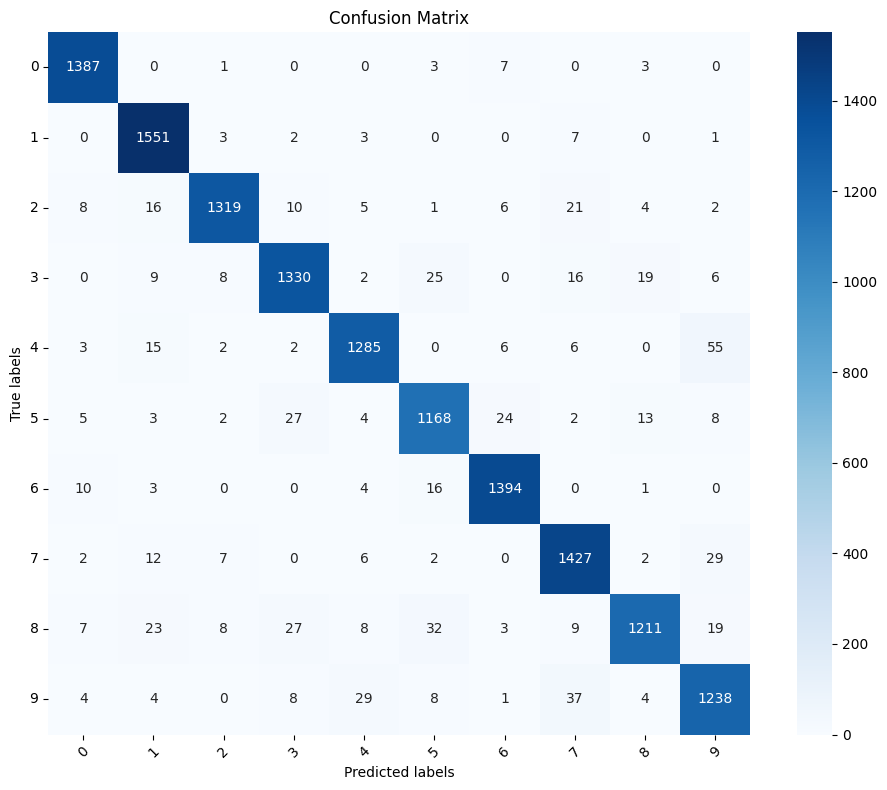

Running KNN with k=2 and distance metric='euclidean'
Accuracy: 0.9507
Macro-Average F1 Score: 0.9499


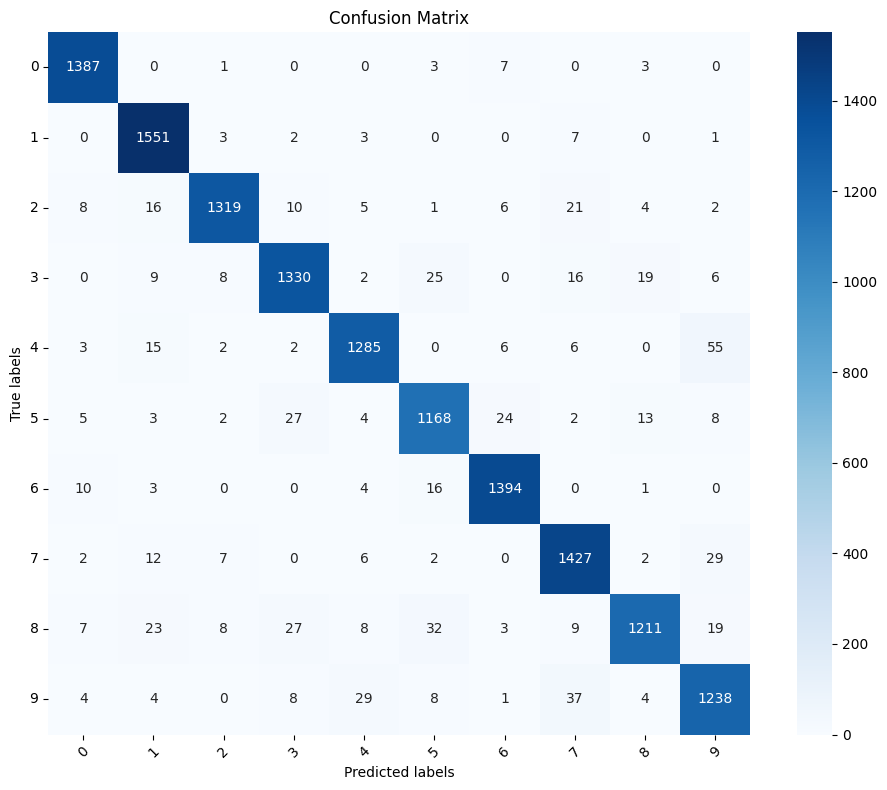

Running KNN with k=3 and distance metric='euclidean'
Accuracy: 0.9518
Macro-Average F1 Score: 0.9512


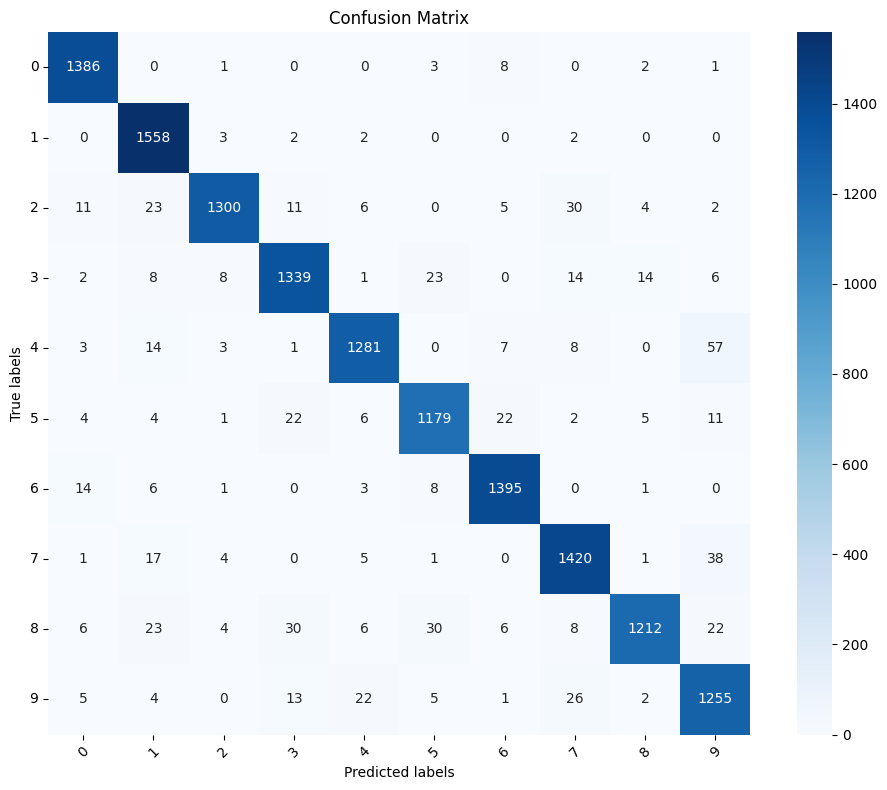

Running KNN with k=4 and distance metric='euclidean'
Accuracy: 0.9532
Macro-Average F1 Score: 0.9527


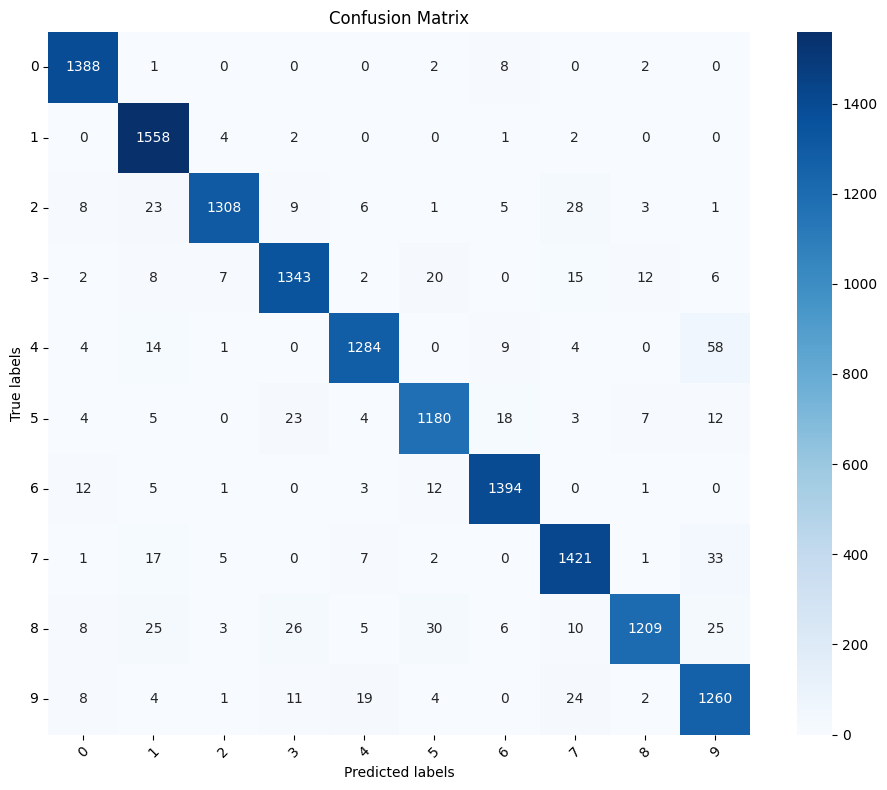

Running KNN with k=5 and distance metric='euclidean'
Accuracy: 0.9506
Macro-Average F1 Score: 0.9501


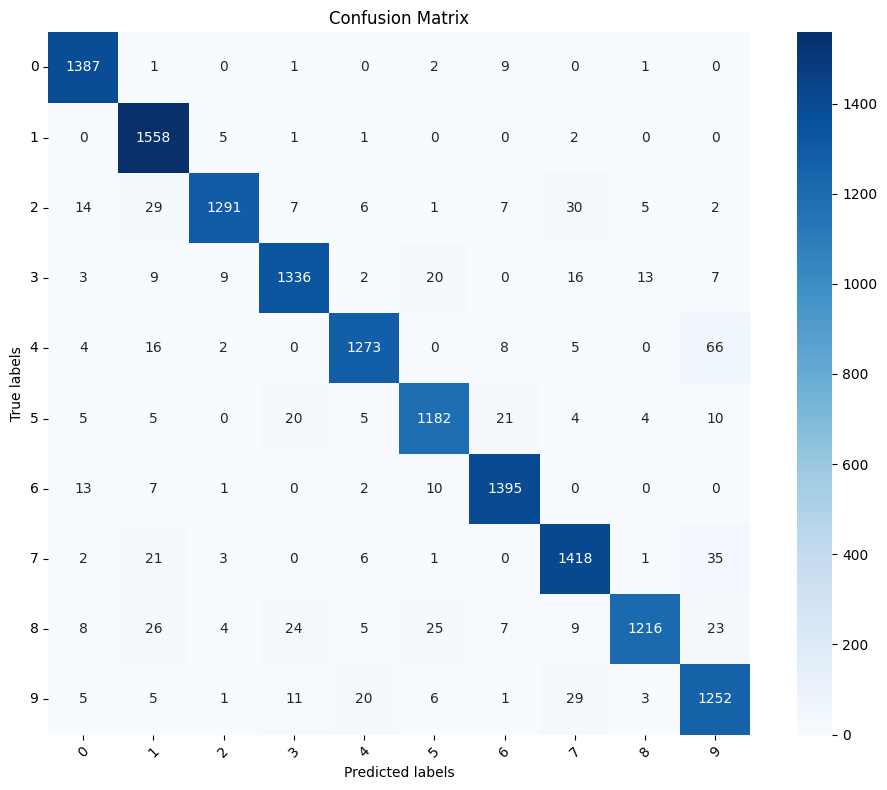

Running KNN with k=1 and distance metric='manhattan'
Accuracy: 0.9426
Macro-Average F1 Score: 0.9417


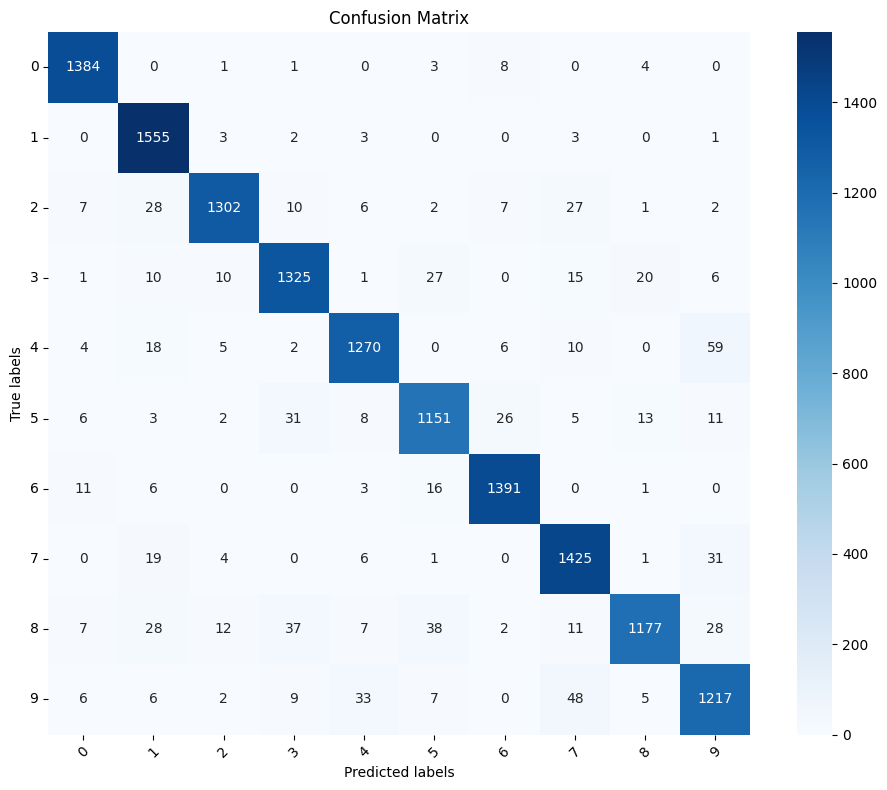

Running KNN with k=2 and distance metric='manhattan'
Accuracy: 0.9426
Macro-Average F1 Score: 0.9417


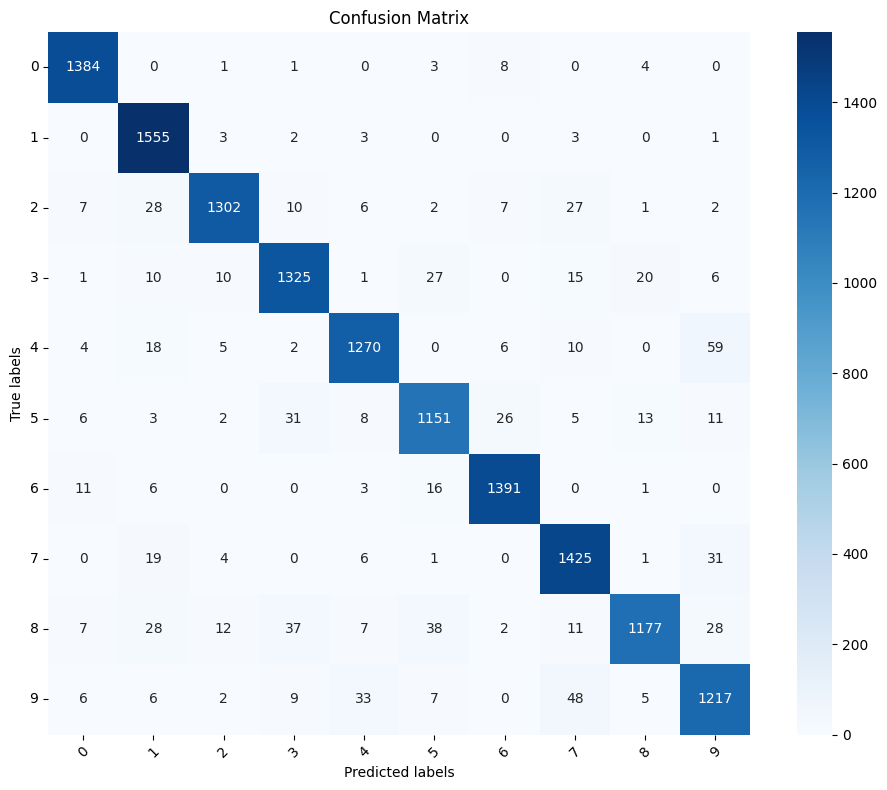

Running KNN with k=3 and distance metric='manhattan'
Accuracy: 0.9438
Macro-Average F1 Score: 0.9431


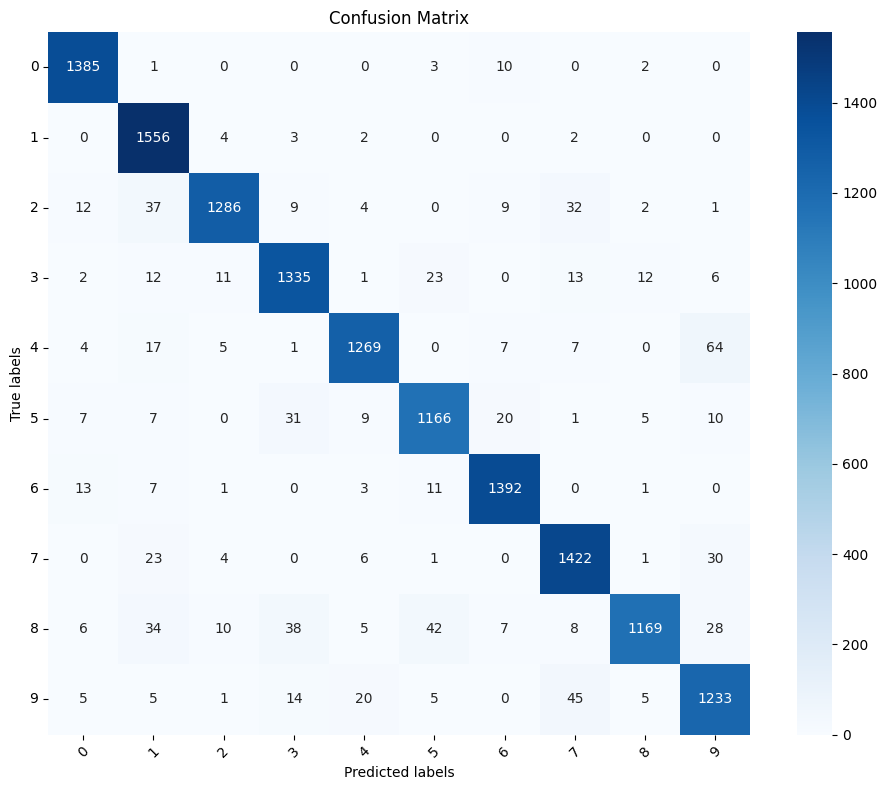

Running KNN with k=4 and distance metric='manhattan'
Accuracy: 0.9448
Macro-Average F1 Score: 0.9441


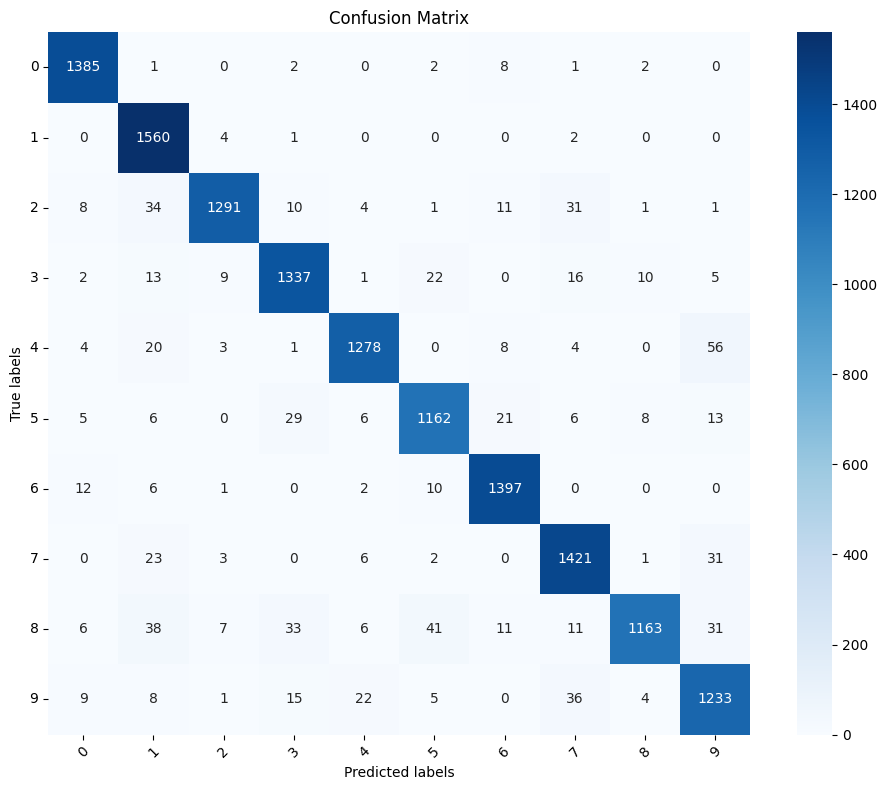

Running KNN with k=5 and distance metric='manhattan'
Accuracy: 0.9409
Macro-Average F1 Score: 0.9403


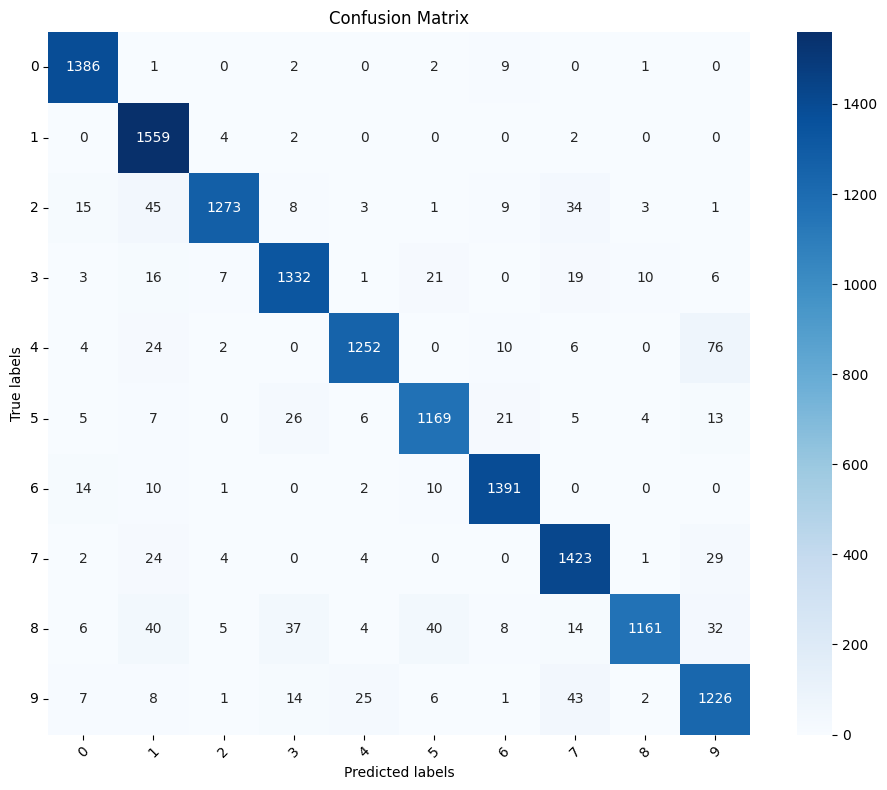

Euclidean Distance Results:
k=1: Accuracy=0.9507, F1 Score=0.9499
k=2: Accuracy=0.9507, F1 Score=0.9499
k=3: Accuracy=0.9518, F1 Score=0.9512
k=4: Accuracy=0.9532, F1 Score=0.9527
k=5: Accuracy=0.9506, F1 Score=0.9501

Manhattan Distance Results:
k=1: Accuracy=0.9426, F1 Score=0.9417
k=2: Accuracy=0.9426, F1 Score=0.9417
k=3: Accuracy=0.9438, F1 Score=0.9431
k=4: Accuracy=0.9448, F1 Score=0.9441
k=5: Accuracy=0.9409, F1 Score=0.9403


In [ ]:
k_values = [1, 2, 3, 4, 5]
knn_model = KNN(k=5)

for distance_metric in ['euclidean', 'manhattan']:
    for k in k_values:
        knn_model.k = k
        print(f"Running KNN with k={k} and distance metric='{distance_metric}'")

        if distance_metric == 'euclidean':
            predictions = k_fold_cross_validation(num_folds=5, k=k, train_x=sampled_train_x, train_y=sampled_train_y, distanceFunction=knn_model.euclidean_distance)
        else:
            predictions = k_fold_cross_validation(num_folds=5, k=k, train_x=sampled_train_x, train_y=sampled_train_y, distanceFunction=knn_model.manhattan_distance)

        acc, f1, _ = evaluate(predictions, sampled_train_y)

        if distance_metric == 'euclidean':
            accuracy_list_euclidean.append(acc)
            f1_list_euclidean.append(f1)
        else:
            accuracy_list_manhattan.append(acc)
            f1_list_manhattan.append(f1)

print("Euclidean Distance Results:")
for k, acc, f1 in zip(k_values, accuracy_list_euclidean, f1_list_euclidean):
    print(f'k={k}: Accuracy={acc:.4f}, F1 Score={f1:.4f}')

print("\nManhattan Distance Results:")
for k, acc, f1 in zip(k_values, accuracy_list_manhattan, f1_list_manhattan):
    print(f'k={k}: Accuracy={acc:.4f}, F1 Score={f1:.4f}')


Next, present the results as a graph with `k` values on the x-axis and classification accuracy on the y-axis. Use a single plot to compare the two versions of the classifier (one using Euclidean and the other using Manhattan distance metric).

Make another graph but with the F1-score on the y-axis this time. The graphs should be properly labeled on axes, with a title, and a legend.

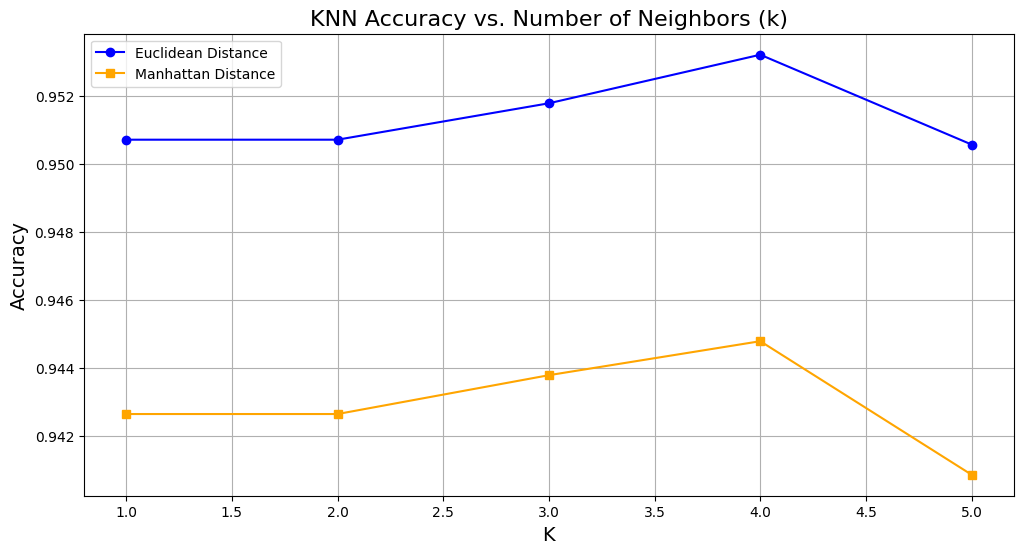

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracy_list_euclidean, marker='o', label='Euclidean Distance', color='blue')
plt.plot(k_values, accuracy_list_manhattan, marker='s', label='Manhattan Distance', color='orange')
plt.title('KNN Accuracy vs. Number of Neighbors (k)', fontsize=16)
plt.xlabel('K', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid()
plt.show()


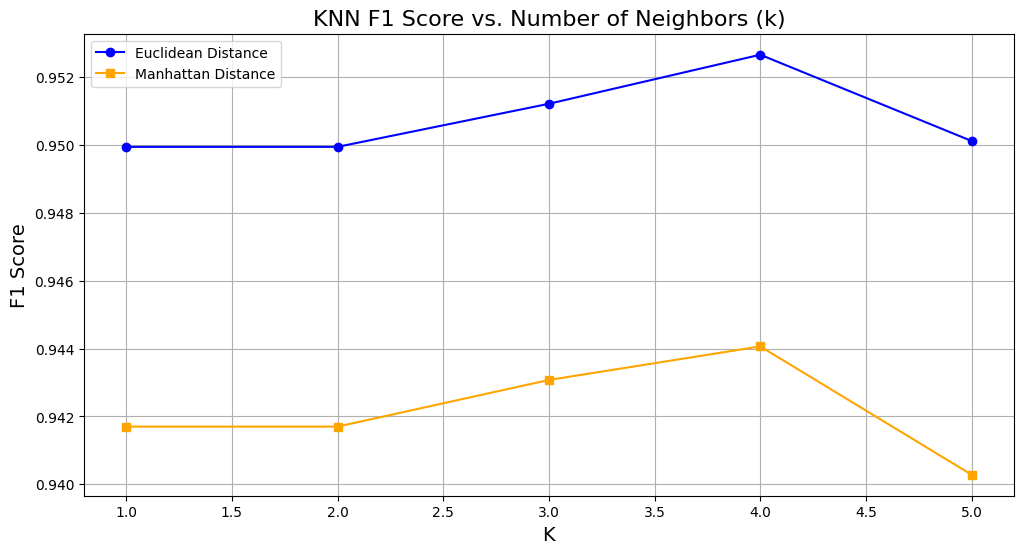

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, f1_list_euclidean, marker='o', label='Euclidean Distance', color='blue')
plt.plot(k_values, f1_list_manhattan, marker='s', label='Manhattan Distance', color='orange')
plt.title('KNN F1 Score vs. Number of Neighbors (k)', fontsize=16)
plt.xlabel('K', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.legend()
plt.grid()
plt.show()


### Task 6: Prediction [12 marks]

Finally, use the best value of `k` for both distance metrics and run it on the test dataset.

Find the confusion matrix, classification accuracy and F1 score and print them.

The confusion matrix must be displayed as a heatmap annotated with the data values. The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.

Accuracy: 0.9682
Macro-Average F1 Score: 0.9681


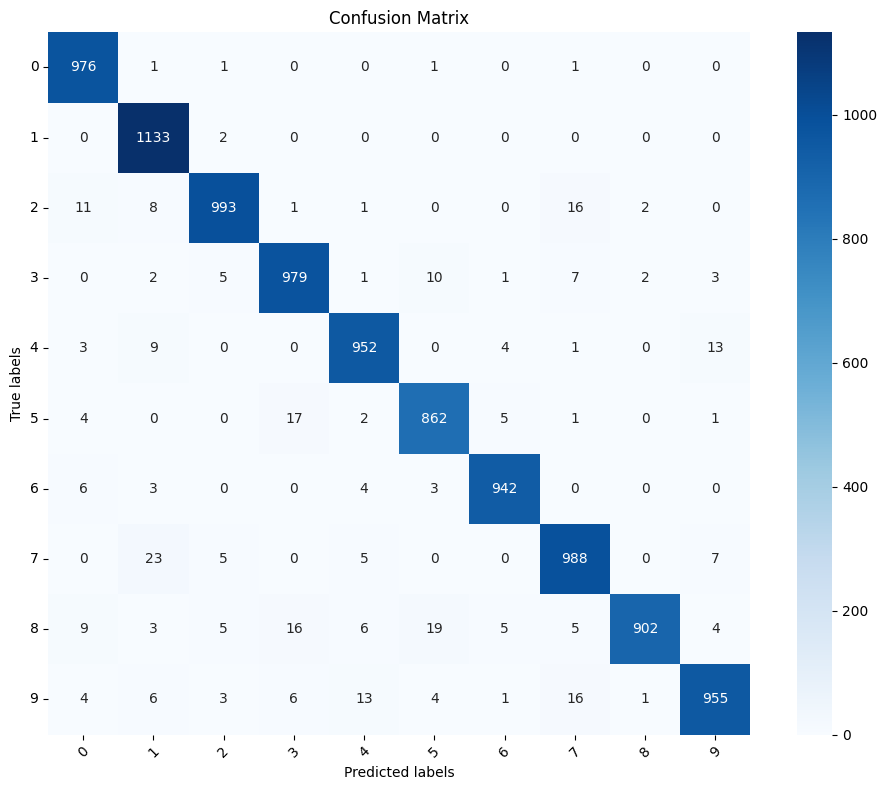

(0.9682,
 0.9680653871474595,
 array([[ 976,    1,    1,    0,    0,    1,    0,    1,    0,    0],
        [   0, 1133,    2,    0,    0,    0,    0,    0,    0,    0],
        [  11,    8,  993,    1,    1,    0,    0,   16,    2,    0],
        [   0,    2,    5,  979,    1,   10,    1,    7,    2,    3],
        [   3,    9,    0,    0,  952,    0,    4,    1,    0,   13],
        [   4,    0,    0,   17,    2,  862,    5,    1,    0,    1],
        [   6,    3,    0,    0,    4,    3,  942,    0,    0,    0],
        [   0,   23,    5,    0,    5,    0,    0,  988,    0,    7],
        [   9,    3,    5,   16,    6,   19,    5,    5,  902,    4],
        [   4,    6,    3,    6,   13,    4,    1,   16,    1,  955]]))

In [ ]:
best_k = 4
knn_model_euclidean = KNN(k=best_k)
knn_model_euclidean.fit(train_x_normalized, train_y)
predictions_euclidean = knn_model_euclidean.predict(test_x_normalized, knn_model_euclidean.euclidean_distance)
evaluate(predictions_euclidean, test_y)

Accuracy: 0.9607
Macro-Average F1 Score: 0.9607


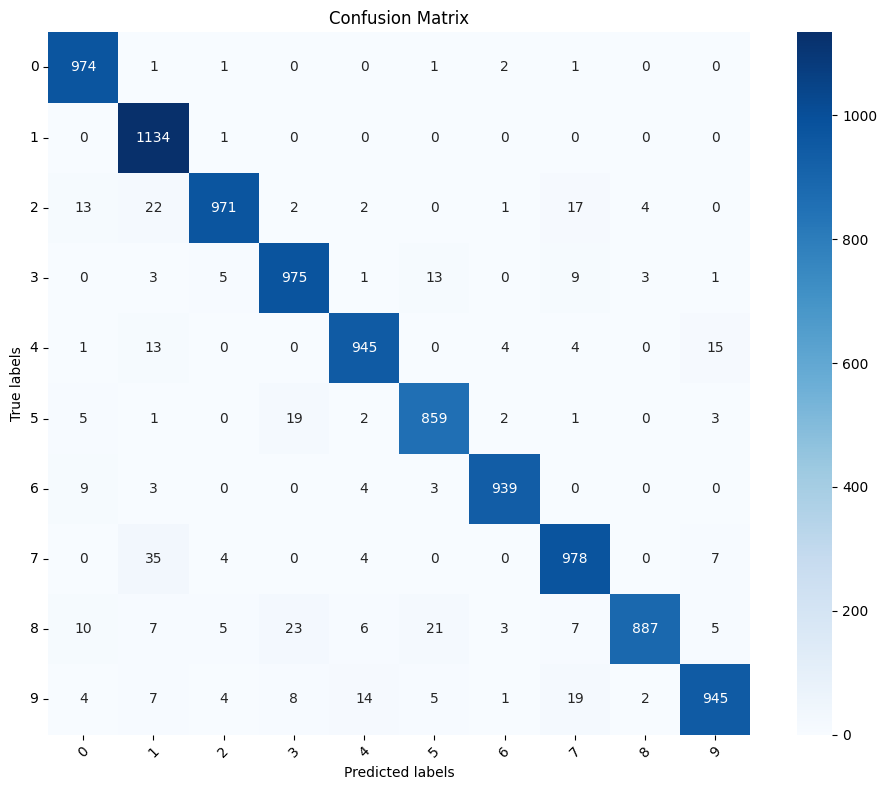

(0.9607,
 0.9607459334240062,
 array([[ 974,    1,    1,    0,    0,    1,    2,    1,    0,    0],
        [   0, 1134,    1,    0,    0,    0,    0,    0,    0,    0],
        [  13,   22,  971,    2,    2,    0,    1,   17,    4,    0],
        [   0,    3,    5,  975,    1,   13,    0,    9,    3,    1],
        [   1,   13,    0,    0,  945,    0,    4,    4,    0,   15],
        [   5,    1,    0,   19,    2,  859,    2,    1,    0,    3],
        [   9,    3,    0,    0,    4,    3,  939,    0,    0,    0],
        [   0,   35,    4,    0,    4,    0,    0,  978,    0,    7],
        [  10,    7,    5,   23,    6,   21,    3,    7,  887,    5],
        [   4,    7,    4,    8,   14,    5,    1,   19,    2,  945]]))

In [ ]:
best_k = 4
knn_model_manhattan = KNN(k=best_k)
knn_model_manhattan.fit(train_x_normalized, train_y)
predictions_manhattan = knn_model_manhattan.predict(test_x_normalized, knn_model_manhattan.manhattan_distance)
evaluate(predictions_manhattan, test_y)

## Part 2: KNN using Scikit-Learn [10 marks]

In this part, you have to use [scikit-learn's k-NN implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to train and test your classifier on the dataset used in Part 1. Repeat the tasks you have done in Part 1 but this time using scikit-learn.

- Use the best value of `k` from part 1 for both manhattan and euclidean distance. You don't need to perform k-fold cross validation this time

- Use scikit-learn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function to calculate the accuracy, the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to calculate macro-average F1 score,
and the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate confusion matrix from the predicted labels.

**NOTE: Use the preprocessed dataset from Part 1**



In [11]:
!pip install scikit-learn==1.4.2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Accuracy (Euclidean Distance): 0.9682
Classification Report (Euclidean Distance):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.95      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.98      0.98      0.98       958
           7       0.95      0.96      0.96      1028
           8       0.99      0.93      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



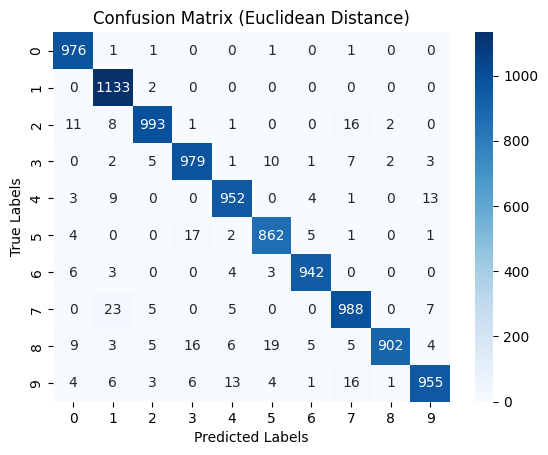

In [12]:
best_k = 4
knn_euclidean = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_euclidean.fit(train_x_normalized, train_y)
pred_y_euclidean = knn_euclidean.predict(test_x_normalized)
accuracy_euclidean = accuracy_score(test_y, pred_y_euclidean)
print(f"Accuracy (Euclidean Distance): {accuracy_euclidean:.4f}")
print("Classification Report (Euclidean Distance):")
print(classification_report(test_y, pred_y_euclidean))

confusion_matrix_euclidean = confusion_matrix(test_y, pred_y_euclidean)
sns.heatmap(confusion_matrix_euclidean, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix (Euclidean Distance)")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy (Manhattan Distance): 0.9607
Classification Report (Manhattan Distance):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.93      1.00      0.96      1135
           2       0.98      0.94      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.95      0.96      0.96       892
           6       0.99      0.98      0.98       958
           7       0.94      0.95      0.95      1028
           8       0.99      0.91      0.95       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



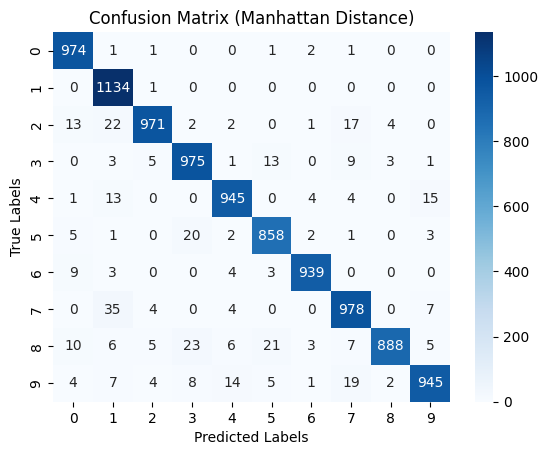

In [13]:
best_k = 4
knn_manhattan = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan')
knn_manhattan.fit(train_x_normalized, train_y)
pred_y_manhattan = knn_manhattan.predict(test_x_normalized)
accuracy_manhattan = accuracy_score(test_y, pred_y_manhattan)
print(f"Accuracy (Manhattan Distance): {accuracy_manhattan:.4f}")
print("Classification Report (Manhattan Distance):")
print(classification_report(test_y, pred_y_manhattan))

confusion_matrix_manhattan = confusion_matrix(test_y, pred_y_manhattan)
sns.heatmap(confusion_matrix_manhattan, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix (Manhattan Distance)")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Part 3: Radius nearest neighbors [50 marks]
<center>
    <img src="https://media.springernature.com/m312/springer-static/image/art%3A10.1134%2FS1054661820030268/MediaObjects/11493_2020_6090_Fig5_HTML.gif?">
</center>

Radius Neighbors Classifier is an extension to the k-nearest neighbors algorithm that makes predictions using all examples in the radius of a new example rather than the k-closest neighbors. Read more about this neighbor-based classifier [here](https://machinelearningmastery.com/radius-neighbors-classifier-algorithm-with-python/#:~:text=Radius%20Neighbors%20Classifier%20is%20a,than%20the%20k%2Dclosest%20neighbors.).

The Radius Neighbors Classifier is similar to KNN in respect that its training involves storing the entire training dataset. However, instead of basing decisions on k-nearest neighbors, the Radius Neighbors Classifier locates all examples in the training dataset that are within a given radius of the new example to make a prediction.

For this part, we will be using the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset).

###Task 1: Data Loading and Preprocessing [12 marks]

The breast cancer dataset comprises of 569 rows and 32 columns. Your task is to design a r-NN classifier that is able to classify breast tumors into malignant (cancerous) or benign (non cancerous).  

In [14]:
df = pd.read_csv('/breast-cancer.csv')
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (569, 32)
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  

In [15]:
df = df.drop(columns=['id'])

df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})

<ipython-input-15-5c651c55b9b6>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})


In [16]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

train_x = train_df.drop(columns=['diagnosis'])
train_y = train_df['diagnosis']
test_x = test_df.drop(columns=['diagnosis'])
test_y = test_df['diagnosis']

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(455, 30)
(455,)
(114, 30)
(114,)


In [17]:
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

def standardize_features(train_x, test_x):
    mean = train_x.mean(axis=0)
    std = train_x.std(axis=0)
    std[std == 0] = 1
    train_x_standardized = (train_x - mean) / std
    test_x_standardized = (test_x - mean) / std

    return train_x_standardized, test_x_standardized

train_x, test_x = standardize_features(train_x, test_x)



### Task 2: Implementing r-NN Classifier [10 marks]

You are now fully equipped to create your own radius nearest neighbor classifier. You can use the following steps as a guide:

- For a test data point, find its distance from all training instances.

- Sort the calculated distances in ascending order based on distance values.

- Choose all of the training examples that are within the radius `r`

- Return the most frequent class of these samples.

**Note:** Sometimes for the radius `r`, it is possible that you will not have any training examples in the given radius for some test data points. In this case, simply return the **majority class** of the dataset.

On the other hand, if there is a tie, you can use a similar strategy as before. Remove the furthest training example from your choosen neighbors to take a vote.

You can reuse parts of your code from the KNN class


---

Complete the following methods:
- `euclidean_distance`
- `manhattan_distance`
- `fit`                
- `get_neighbors`      
- `predict`



In [18]:
class RNN:
  def __init__(self, r):
      self.r = r
      self.train_x = None
      self.train_y = None

  def euclidean_distance(self, x1, x2):
      return np.sqrt(np.sum((x2 - x1) ** 2, axis=1))

  def manhattan_distance(self, x1, x2):
      return np.sum(np.abs(x2 - x1), axis=1)

  def fit(self, train_x, train_y):
      self.train_x = train_x
      self.train_y = train_y

  def get_neighbors(self, new_point, distancefunc):
      distances = distancefunc(new_point, self.train_x)
      neighbors_in_radius = self.train_y[distances <= self.r]
      if len(neighbors_in_radius) == 0:
          majority_class = np.bincount(self.train_y).argmax()
          return [majority_class]

      return neighbors_in_radius

  def predict(self, test_x, distancefunc):
      predictions = []
      for point in test_x:
          neighbors = self.get_neighbors(point, distancefunc)
          prediction = np.bincount(neighbors).argmax()
          predictions.append(prediction)

      return np.array(predictions)

### Task 3: k-fold Cross Validation [18 marks]

In this part, for **euclidean distance**, uniformally sample **20** different values of `r` from the range `3.5-5.5`. Use these values of `r` for 5-fold cross validation using the functions you implemented in part 1.

For **manhattan distance** uniformally sample **20** different values of `r` from the range `15.5-17.5`. Use these values of `r` for 5-fold cross validation using the functions you implemented in part 1.

Again, for each `r`, conduct the cross validation for both distances and report accuracy and macro-f1 score for each `r` and distance. You can use sklearn evaluation metrics to report the results

**Store these results for plotting later.**

In [19]:
from sklearn.metrics import f1_score, accuracy_score

def k_fold_cross_validation_rnn(num_folds, r, train_x, train_y, distanceFunction):
  fold_size = len(train_x) // num_folds
  all_predictions = np.zeros(len(train_x), dtype=int)

  for fold in range(num_folds):
      val_start = fold * fold_size
      val_end = (fold + 1) * fold_size if fold != num_folds - 1 else len(train_x)
      val_x = train_x[val_start:val_end]
      val_y = train_y[val_start:val_end]
      fold_train_x = np.concatenate((train_x[:val_start], train_x[val_end:]), axis=0)
      fold_train_y = np.concatenate((train_y[:val_start], train_y[val_end:]), axis=0)
      rnn = RNN(r)
      rnn.fit(fold_train_x, fold_train_y)
      predictions = rnn.predict(val_x, distanceFunction)
      all_predictions[val_start:val_end] = predictions

  return all_predictions



In [20]:
accuracy_list_euclidean = []
f1_list_euclidean = []
accuracy_list_manhattan = []
f1_list_manhattan = []
r_values_euclidean = np.linspace(3.5, 5.5, 20)
r_values_manhattan = np.linspace(15.5, 17.5, 20)

r_values_euclidean = np.sort(r_values_euclidean)
r_values_manhattan = np.sort(r_values_manhattan)


In [21]:
rnn_model = RNN(r=None)
for r in r_values_euclidean:
    rnn_model.r = r
    predictions = k_fold_cross_validation_rnn(num_folds=5, r=r, train_x=train_x, train_y=train_y, distanceFunction=rnn_model.euclidean_distance)
    accuracy = accuracy_score(train_y, predictions)
    macro_f1 = f1_score(train_y, predictions, average='macro')
    accuracy_list_euclidean.append(accuracy)
    f1_list_euclidean.append(macro_f1)

print("Euclidean Distance Results:")
for r, acc, f1 in zip(r_values_euclidean, accuracy_list_euclidean, f1_list_euclidean):
    print(f'r={r:.2f}: Accuracy={acc:.4f}, F1 Score={f1:.4f}')


Euclidean Distance Results:
r=3.50: Accuracy=0.8681, F1 Score=0.8433
r=3.61: Accuracy=0.8747, F1 Score=0.8521
r=3.71: Accuracy=0.8769, F1 Score=0.8550
r=3.82: Accuracy=0.8857, F1 Score=0.8659
r=3.92: Accuracy=0.8967, F1 Score=0.8795
r=4.03: Accuracy=0.9055, F1 Score=0.8910
r=4.13: Accuracy=0.9033, F1 Score=0.8882
r=4.24: Accuracy=0.9055, F1 Score=0.8910
r=4.34: Accuracy=0.9143, F1 Score=0.9018
r=4.45: Accuracy=0.9099, F1 Score=0.8964
r=4.55: Accuracy=0.9055, F1 Score=0.8906
r=4.66: Accuracy=0.9033, F1 Score=0.8878
r=4.76: Accuracy=0.9055, F1 Score=0.8906
r=4.87: Accuracy=0.9033, F1 Score=0.8878
r=4.97: Accuracy=0.9033, F1 Score=0.8878
r=5.08: Accuracy=0.9033, F1 Score=0.8878
r=5.18: Accuracy=0.9055, F1 Score=0.8906
r=5.29: Accuracy=0.9055, F1 Score=0.8906
r=5.39: Accuracy=0.9055, F1 Score=0.8906
r=5.50: Accuracy=0.9055, F1 Score=0.8906


In [22]:
rnn_model = RNN(r=None)
for r in r_values_manhattan:
    rnn_model.r = r
    predictions = k_fold_cross_validation_rnn(num_folds=5, r=r, train_x=train_x, train_y=train_y, distanceFunction=rnn_model.manhattan_distance)
    accuracy = accuracy_score(train_y, predictions)
    macro_f1 = f1_score(train_y, predictions, average='macro')
    accuracy_list_manhattan.append(accuracy)
    f1_list_manhattan.append(macro_f1)

print("Manhattan Distance Results:")
for r, acc, f1 in zip(r_values_manhattan, accuracy_list_manhattan, f1_list_manhattan):
    print(f'r={r:.2f}: Accuracy={acc:.4f}, F1 Score={f1:.4f}')


Manhattan Distance Results:
r=15.50: Accuracy=0.8835, F1 Score=0.8630
r=15.61: Accuracy=0.8857, F1 Score=0.8659
r=15.71: Accuracy=0.8857, F1 Score=0.8659
r=15.82: Accuracy=0.8879, F1 Score=0.8687
r=15.92: Accuracy=0.8879, F1 Score=0.8687
r=16.03: Accuracy=0.8923, F1 Score=0.8748
r=16.13: Accuracy=0.8901, F1 Score=0.8725
r=16.24: Accuracy=0.8945, F1 Score=0.8776
r=16.34: Accuracy=0.8967, F1 Score=0.8799
r=16.45: Accuracy=0.8967, F1 Score=0.8799
r=16.55: Accuracy=0.8945, F1 Score=0.8772
r=16.66: Accuracy=0.8923, F1 Score=0.8748
r=16.76: Accuracy=0.8923, F1 Score=0.8744
r=16.87: Accuracy=0.8967, F1 Score=0.8799
r=16.97: Accuracy=0.8967, F1 Score=0.8799
r=17.08: Accuracy=0.8967, F1 Score=0.8799
r=17.18: Accuracy=0.8989, F1 Score=0.8827
r=17.29: Accuracy=0.8989, F1 Score=0.8827
r=17.39: Accuracy=0.8989, F1 Score=0.8827
r=17.50: Accuracy=0.9033, F1 Score=0.8882


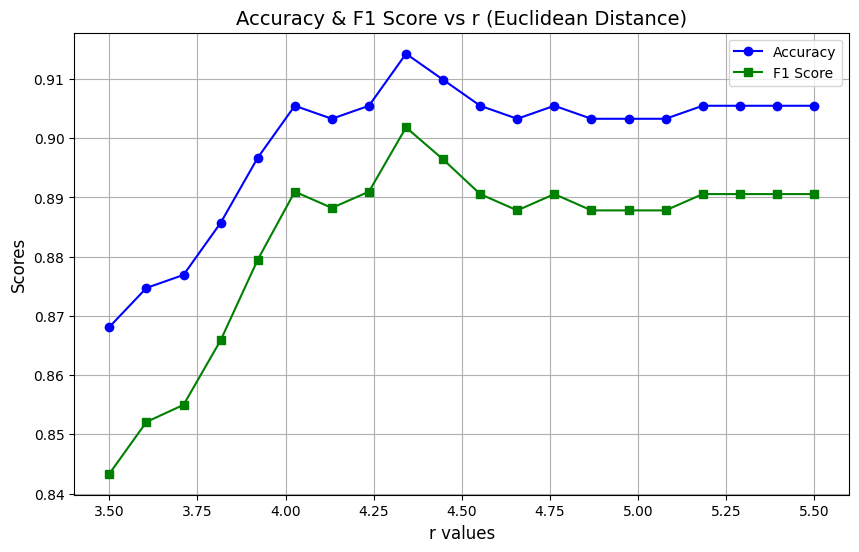

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(r_values_euclidean, accuracy_list_euclidean, label='Accuracy', marker='o', color='blue')
plt.plot(r_values_euclidean, f1_list_euclidean, label='F1 Score', marker='s', color='green')
plt.xlabel('r values', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Accuracy & F1 Score vs r (Euclidean Distance)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

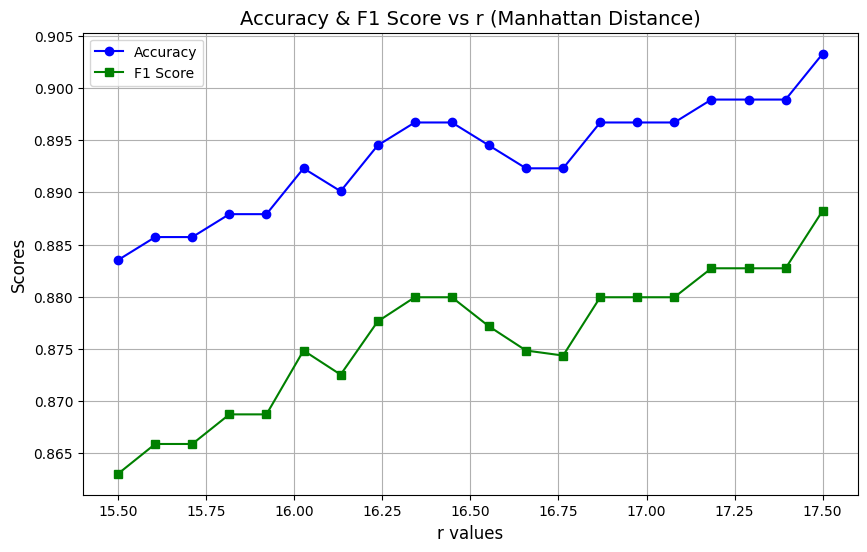

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(r_values_manhattan, accuracy_list_manhattan, label='Accuracy', marker='o', color='blue')
plt.plot(r_values_manhattan, f1_list_manhattan, label='F1 Score', marker='s', color='green')
plt.xlabel('r values', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Accuracy & F1 Score vs r (Manhattan Distance)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

QUESTION: Discuss how the value of `r` relates to overfitting and underfitting. [2 marks]


Answer: When r is small, the model will consider only a few neighbors that fall within this tight radius, leading to overfitting as the model will be too sensitive to the data that lies within its radius.
When r is large, the model will consider many a much larger number neighbors that fall within this bigger radius, leading to underfitting as the model will have too much data to compete with.

### Task 4: Prediction [10 marks]

Finally, use the best value of `r` for both distance metrics and run it on the test dataset. Make sure you do not harcode values of `r` in this part.

Find the confusion matrix, classification accuracy and macro F1 score and print them. You can use Sklearn's evaluation metrics in this part as well.

The confusion matrix must be displayed as a heatmap annotated with the data values. The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.

Euclidean Distance - Best r: 4.34
Accuracy: 0.8772, Macro F1 Score: 0.8652



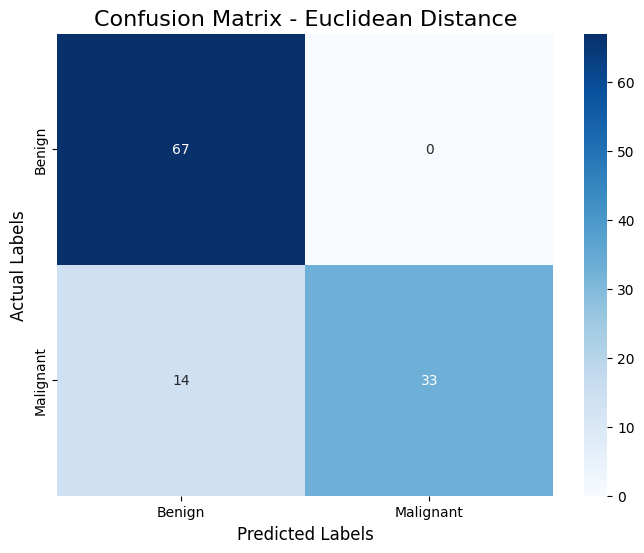

In [25]:
best_r = r_values_euclidean[np.argmax(accuracy_list_euclidean)]
rnn_euclidean = RNN(r=best_r)
rnn_euclidean.fit(train_x, train_y)
predictions_euclidean = rnn_euclidean.predict(test_x, rnn_euclidean.euclidean_distance)
conf_matrix_euclidean = confusion_matrix(test_y, predictions_euclidean)
accuracy_euclidean = accuracy_score(test_y, predictions_euclidean)
f1_euclidean = f1_score(test_y, predictions_euclidean, average='macro')
print(f"Euclidean Distance - Best r: {best_r:.2f}")
print(f"Accuracy: {accuracy_euclidean:.4f}, Macro F1 Score: {f1_euclidean:.4f}\n")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_euclidean, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Euclidean Distance', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)
plt.show()


Manhattan Distance - Best r: 17.50
Accuracy: 0.8860, Macro F1 Score: 0.8755



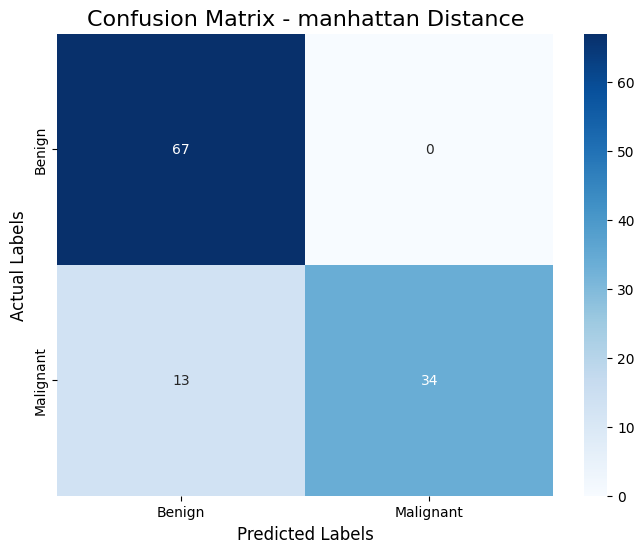

In [26]:
best_r = r_values_manhattan[np.argmax(accuracy_list_manhattan)]
rnn_manhattan = RNN(r=best_r)
rnn_manhattan.fit(train_x, train_y)
predictions_manhattan = rnn_manhattan.predict(test_x, rnn_manhattan.manhattan_distance)
conf_matrix_manhattan = confusion_matrix(test_y, predictions_manhattan)
accuracy_manhattan = accuracy_score(test_y, predictions_manhattan)
f1_manhattan = f1_score(test_y, predictions_manhattan, average='macro')
print(f"Manhattan Distance - Best r: {best_r:.2f}")
print(f"Accuracy: {accuracy_manhattan:.4f}, Macro F1 Score: {f1_manhattan:.4f}\n")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_manhattan, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - manhattan Distance', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('Actual Labels', fontsize=12)
plt.show()


QUESTION: Explain why rNN classifier would have been a poor choice for the MNIST dataset. Discuss with respect to curse of dimentionality. [2 marks]

Answer: The MNIST dataset consists of 28x28 images, which translates into 784 features due to which the data points become sparse in the large volume space. In r-NN, a fixed radius is used to determine the neighbors of a data point. Due to the large volume most points may lie outside this radius. This leads to the model failing to find enough neighbors or any at all.